this is a script to plot out stago hits from BLAST against nt database using the stago reads from the rgBLAST. using the ntBLAST output file.

In [360]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import subprocess as sub
from ete3 import NCBITaxa 
ncbi = NCBITaxa()

In [361]:
BASEDIR = '/home/yiheng/analysis/WGS/total_stago.fasta.ntblastoutput'

In [362]:
df_headers = ['qseqid', 'sseqid', 'evalue', 'bitscore', 'length', 'pident', 'nident', 'sgi', 'sacc', 'staxids', 'sscinames', 'scomnames', 'sskingdoms']

In [363]:
stago_df = pd.read_csv(BASEDIR, names=df_headers, sep='\t')

In [364]:
for columns in ['sseqid', 'evalue', 'bitscore', 'sgi', 'sacc', 'sscinames', 'scomnames', 'sskingdoms']:
    del stago_df[columns]

In [365]:
# as the concate before will result the staxid into a string
# so now change the string back to float so it can be recognized by the NCBITaxa
for taxid in stago_df['staxids']:
    if ';' in str(taxid):
        taxid = taxid.split(';')[0]
    else:
        pass
    float(taxid)

In [366]:
def search_rank_output_name_append_column(df, staxid_column, rank_search):
    """Input df, staxid_column from same df and rank_search (a desired taxonomic rank 
    from each staxid's lineage), outputs taxonomic name corresponding to rank_search or 'Unclassified' if
    unavailable and appends to df row by row"""
    rank_list = []
    for read_index in range(0, len(staxid_column)):
        taxid = ''
        if ';' in str(staxid_column[read_index]):
            taxid = staxid_column[read_index].split(';')[0]
        else:
            taxid = staxid_column[read_index]
        
        taxid_lineage = ''
        taxid_lineage = ncbi.get_lineage(taxid)
        
        names = ''
        names = ncbi.get_taxid_translator(taxid_lineage)
        
        ranks = ''
        ranks = ncbi.get_rank(taxid_lineage) #Dict
        
        ranks2names = ''
        ranks2names = {ranks[k]:names[k] for k in names.keys() & ranks}
        
        if rank_search in ranks2names.keys():
            rank_list.append(ranks2names[rank_search])#if rank in dict, print name
        else:
            rank_list.append('Unclassified')
    df[rank_search] = rank_list
# NOTE: Appending is always slow, try and find a better way e.g df.apply to a column based on staxids column

In [367]:
rank_list = ['superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']
for rank in rank_list:
    search_rank_output_name_append_column(stago_df, 
                                          stago_df.staxids, 
                                          rank)

In [368]:
stago_df['nident/length'] = stago_df.nident/stago_df.length*100

In [369]:
stago_df_pivot = stago_df.pivot_table(values='phylum', index=['order', 'genus'], aggfunc='count')

In [370]:
excel_file = '/home/yiheng/analysis/WGS/Book1.xlsx'

In [371]:
modified_stago_pivot_df = pd.read_excel(excel_file)
modified_stago_pivot_df.reset_index(drop=True, inplace=True)

In [372]:
modified_stago_pivot_df.head()

,order,genus,phylum
0,Agaricales,Tricholoma,1
1,Botryosphaeriales,Diplodia,1
2,Capnodiales,Catenulostroma,1
3,Capnodiales,Sphaerulina,1
4,Capnodiales,Teratosphaeria,1


In [373]:
order_list = set(modified_stago_pivot_df.order)
new_order_list = []
sum_list = []
for x in order_list:
    new_order_list.append(x)
    subset_df = modified_stago_pivot_df.loc[modified_stago_pivot_df['order'] == x]   
    sum_list.append(subset_df['phylum'].sum())


In [374]:
order_df = pd.DataFrame({'number':sum_list, 'order':new_order_list})
order_df = order_df[['order', 'number']].sort_values(by='order').reset_index(drop=True)

In [396]:
order_df.head()

,order,number
0,Agaricales,1
1,Botryosphaeriales,1
2,Capnodiales,27
3,Cercomonadida,1
4,Cystofilobasidiales,1


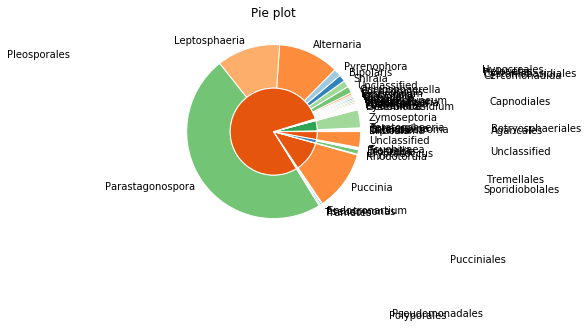

In [397]:
fig, ax = plt.subplots()

width = 0.5

cm = plt.get_cmap("tab20c")
cin = cm(np.array([0,2,5,6,9,10]))
cout = cm(np.arange(3)*4)
labels = modified_stago_pivot_df['genus']
pie, _ = ax.pie(modified_stago_pivot_df['phylum'], radius=1,labels=labels , colors=cin)
plt.setp( pie, width=width, edgecolor='white')


pie2, _ = ax.pie(order_df['number'], radius=1-width, labels=order_df['order'],
                                      labeldistance=5, colors=cout)
plt.setp( pie2, width=1-width, edgecolor='white')
ax.set(aspect="equal", title='Pie plot')
plt.show()

In [398]:
np.array([0,2,5,6,9,10])

array([ 0,  2,  5,  6,  9, 10])

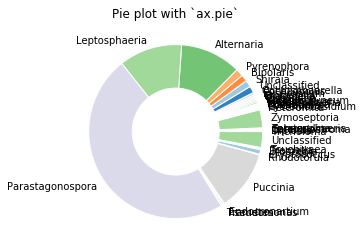

In [400]:
fig, ax = plt.subplots()

width = 0.5

cm = plt.get_cmap("tab20c")
cin = cm(np.array([0,2,5,6,9,10,15,22,29,33,56]))
cout = cm(np.arange(3)*4)
labels = modified_stago_pivot_df['genus']
pie, _ = ax.pie(modified_stago_pivot_df['phylum'], radius=1,labels=labels , colors=cin)
plt.setp( pie, width=width, edgecolor='white')
ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

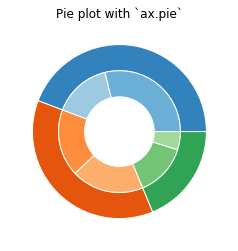

In [402]:
fig, ax = plt.subplots()

size = 0.3
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(vals.flatten(), radius=1-size, colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Pie plot with `ax.pie`')
plt.show()

In [71]:
vals = np.array([[60., 32.], [37., 40., 50.], [29., 10.]], dtype=object)

In [72]:
def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

In [74]:
cmap = matplotlib.cm.get_cmap('tab20c')


TypeError: tuple indices must be integers or slices, not float

In [69]:
cout

array([[ 0.19215686,  0.50980392,  0.74117647,  1.        ],
       [ 0.90196078,  0.33333333,  0.05098039,  1.        ],
       [ 0.19215686,  0.63921569,  0.32941176,  1.        ]])